In [1]:
from pandas import read_csv , concat , DataFrame
import numpy as np
from collections import Counter
from pprint import pprint
import math
import csv
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# import the training data as chunks
dataFrame = read_csv('data/training.csv',header = None)

KeyboardInterrupt: 

In [19]:
def getHighestWordList():
    location = 'data/training.csv'
    length = 61189
    data  = [np.empty([3000,61188]) for x in range(20)]
    c = [0 for x in range(20)]
    v = length -1
    b = 1/v
    
    with open(location, 'r') as f:
        reader = csv.reader(f)
        count = 1
        for row in reader:
            label = int(row[length])-1
            newData = row[1:length]
            data[label][c[label]] = newData
            c[label]+=1
            count = count+1
            if (count % 1000 == 0):
                print("looping")
        print ("done")
    f.close()    
    data = [data[x][0:(c[x]+1)] for x in range(20)]
    
    total = [x.shape[0] for x in data]
    totalWords = [np.sum(x) for x in data]
    xCounts = np.empty([20,61188])
    for i in range(20):
        xCounts[i]=np.sum(data[i],axis=0)
    py1 = total/np.sum(total)
    pxy1 = np.array([(x[0]+b)/(x[1]+(b*length)) for x in zip(xCounts,totalWords)])
    pxy = np.log2(pxy1)
    py = np.log2(py1)
    pxyt = pxy.transpose()
    
    xsum = xCounts.sum()
    px = np.divide(np.add(1,xCounts).sum(axis=0),xsum)
    
    nw = ((pxy1.transpose()*py1).sum(axis=1))
    nw1 = nw/(px)
    
    highestindex = np.argsort(-nw1).tolist()
    
    vocabname = "data/vocabulary.txt" 
    vocab = []
    f = open(vocabname)
    filecontents = f.readlines()
    for line in filecontents:
        vocab.append(line[0:-1])
    print ("done")
    
    highestwords = [vocab[highestindex[i]] for i in range(100)]
    print (highestwords)   

In [20]:
getHighestWordList()

looping
looping
looping
looping
looping
looping
looping
looping
looping
looping
looping
looping
done
done
['wolverine', 'shipping', 'hulk', 'sale', 'sabretooth', 'comics', 'liefeld', 'hobgoblin', 'obo', 'bagged', 'spider', 'punisher', 'condition', 'forsale', 'ghost', 'offer', 'marvel', 'stereo', 'meg', 'scsi', 'manuals', 'rider', 'mint', 'art', 'cable', 'brand', 'motherboard', 'controller', 'drive', 'mhz', 'mb', 'mutants', 'panther', 'disks', 'cd', 'drives', 'pom', 'ide', 'monitor', 'modem', 'simms', 'floppy', 'keown', 'card', 'adapter', 'battery', 'ram', 'sony', 'printer', 'excellent', 'hz', 'disk', 'manual', 'price', 'cassette', 'cod', 'pin', 'hd', 'warranty', 'dx', 'mcfarlane', 'tape', 'offers', 'appears', 'selling', 'asking', 'mac', 'amp', 'nm', 'duo', 'bios', 'vf', 'bike', 'vga', 'lc', 'port', 'connector', 'items', 'sell', 'external', 'upgrade', 'board', 'sega', 'quadra', 'app', 'geoffrey', 'cpu', 'fpu', 'cards', 'prices', 'annual', 'dod', 'video', 'slot', 'car', 'audio', 'appeara

In [ ]:
def naiveBayes(traindf, testdf, validating = False, beta = 1): 
    trainingLabels = traindf.iloc[:,-1].values
    validatingLabels = testdf.iloc[:,-1].values
    validatingLabelsNames = testdf.iloc[:,0].values
    validatingSet = dict([list(a) for a in zip(validatingLabelsNames, validatingLabels)])
    totalDocuments = len(trainingLabels)
    totalValidationDocuments = len(validatingLabels)
    
    print("the length of trainningLabels is ====  " + str(totalDocuments))
    print("the length of ValidatingLabels is ====  " + str(totalValidationDocuments))
    
    traindf.drop(traindf.columns[[-1,0]],axis = 1, inplace=True)
    trainingClassCount = Counter()
    for val in trainingLabels:
        trainingClassCount[val] += 1
    
    allLabels = np.unique(trainingLabels)
    totalClassCount = len(allLabels)
    sortedClassCount = sorted(trainingClassCount.items())
    classCount = [y for (x,y) in sortedClassCount]
    #print(classCount)
    logPriorProb = [math.log(x/totalDocuments) for x in classCount]
    trainingMatrix = np.array(traindf.values)
    totalWords = len(trainingMatrix[0])
   
    dividedOnClass = [[x for x, y in zip(trainingMatrix,trainingLabels) if y == c] for c in allLabels]
    tempTable = [np.array(val).sum(axis=0)for val in dividedOnClass]
    smoother = beta if validating else 1 / totalWords
    #print(smoother)
    smoothCount = np.array(tempTable) + smoother
    totalWordInEachClass = [sum(val) for val in tempTable]
    totalWordInEachClassSmooth = np.array(totalWordInEachClass) + beta*totalWords
    likelihood = np.array([ x / y for x , y in zip (smoothCount,totalWordInEachClassSmooth)])
    logLikelihood = np.array([np.log(val) for val in likelihood])
    
    
    testingDataFrame = testdf.iloc[:, :-1] if validating else testdf
    testingId = testingDataFrame.iloc[:,0].values
    #pprint(testingDataFrame)
    #print(testingId)
    testingDataFrame.drop(testingDataFrame.columns[0,],axis=1,inplace=True)
    testingVals = np.array(testingDataFrame.values)
    #print(testingVals)
    probEstimation = [logLikelihood.dot(val) for val in testingVals]
    totalProbEstimation = [[x + y for x,y in zip(logPriorProb, val)] for val in probEstimation]
    prediction = [val.index(max(val))+1 for val in totalProbEstimation]
    csvData = [ [docId , p]  for docId,p in zip (testingId,prediction)]
    if not(validating):
        csvData = [['id','class']] + csvData
        with open('data/submission.csv', 'w',newline='') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(csvData)
    
    return (validatingSet , dict(csvData))


In [ ]:
def accuracy(predicted, actual):    
    predictiondict =  predicted
    actualdict = actual
    totalwords = len(predicted)
    correct = 0
    for key in actual.keys():
        if actual.get(key) == predicted.get(key):
            correct += 1
    print("accuracy =========="+ str(correct/totalwords))
    return (correct/totalwords)

In [ ]:
trainningdf = read_csv('data/testing.csv',header = None)

In [ ]:
trndf, tstdf = train_test_split(dataFrame, test_size=0.2)

#x = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1]
x = np.arange(0.00001, 1, 0.02)
x = [np.log(x) for xx in x]
y =[]
for beta in x:
    validating, prediction = naiveBayes(traindf = trndf.copy(), testdf= tstdf.copy(), validating = True, beta = beta)
    y.append(accuracy(predicted = prediction, actual = validating))
    print(y)

100


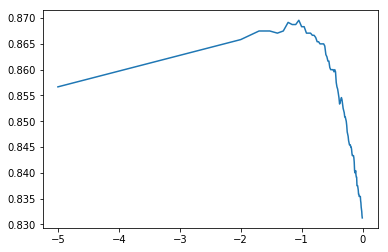

In [32]:
#value saved after running the algorithm for 2 hours with 100 beta values.
x = np.arange(0.00001, 1, 0.01)
x = np.log10(x)
y = [0.8566666666666667, 0.8658333333333333, 0.8675, 0.8675, 0.8670833333333333, 0.8675, 0.8691666666666666, 0.86875, 
0.86875, 0.8695833333333334, 0.8683333333333333, 0.8683333333333333, 0.8670833333333333, 0.8670833333333333, 0.8670833333333333,
0.8666666666666667, 0.8666666666666667, 0.86625, 0.8654166666666666, 0.8654166666666666, 0.865, 0.865, 0.865, 0.865, 
0.8645833333333334, 0.8629166666666667, 0.8625, 0.8616666666666667, 0.8616666666666667, 0.8604166666666667, 0.86, 0.86, 
0.86, 0.86, 0.8595833333333334, 0.86, 0.8595833333333334, 0.8575, 0.8566666666666667, 0.85625, 0.8554166666666667,
0.8545833333333334, 0.8533333333333334, 0.85375, 0.8541666666666666, 0.8545833333333334, 0.8541666666666666, 0.8533333333333334,
0.8525, 0.8520833333333333, 0.8516666666666667, 0.8508333333333333, 0.8508333333333333, 0.8504166666666667, 0.85,
0.8491666666666666, 0.8479166666666667, 0.8475, 0.8470833333333333, 0.84625, 0.8458333333333333, 0.8454166666666667, 
0.8454166666666667, 0.8454166666666667, 0.845, 0.845, 0.8445833333333334, 0.84375, 0.8433333333333334, 0.8433333333333334, 
0.8433333333333334, 0.8433333333333334, 0.8429166666666666, 0.8420833333333333, 0.8404166666666667, 0.84, 0.84, 
0.8404166666666667, 0.8395833333333333, 0.8391666666666666, 0.8391666666666666, 0.8375, 0.8375, 0.8375, 0.8370833333333333, 
0.8366666666666667, 0.8358333333333333, 0.8358333333333333, 0.8354166666666667, 0.8354166666666667, 0.8354166666666667, 
0.8354166666666667, 0.8354166666666667, 0.8345833333333333, 0.8341666666666666, 0.8333333333333334, 0.8329166666666666, 
0.8325, 0.8316666666666667, 0.83125]

print(len(y))
plt.plot(x,y)
plt.show()

In [ ]:
#confusuion matrix

def confusionMatrix(actual, predicion):
    classes = set(actual.values())
    size = len(classes)
    matrix = np.zeros(shape=(size,size))
    
    for k,v in prediction.items():
         matrix[v-1][actual.get(k)-1] += 1
    return matrix


In [ ]:
cMatrix = DataFrame(confusionMatrix(actual = validating, predicion = prediction))
print(dataFrame.head())

In [25]:
x = np.arange(1, 500, 10)
x = np.sqrt(x)

print(x)

[ 1.          3.31662479  4.58257569  5.56776436  6.40312424  7.14142843
  7.81024968  8.42614977  9.          9.53939201 10.04987562 10.53565375
 11.         11.44552314 11.87434209 12.28820573 12.68857754 13.07669683
 13.45362405 13.82027496 14.17744688 14.52583905 14.86606875 15.19868415
 15.5241747  15.84297952 16.15549442 16.46207763 16.76305461 17.05872211
 17.34935157 17.63519209 17.91647287 18.1934054  18.46618531 18.734994
 19.         19.26136028 19.5192213  19.77371993 20.02498439 20.27313493
 20.51828453 20.76053949 21.         21.23676058 21.47091055 21.70253441
 21.9317122  22.15851981]
